In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from torch.utils.data import DataLoader
import random

## Load Data

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset_name = "imdb"
data = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
imdb_df_train = pd.DataFrame(data['train'])
imdb_df_train_0 = imdb_df_train.loc[imdb_df_train.index <= 5000]
imdb_df_train_1 = imdb_df_train.loc[imdb_df_train.index >= 20000]
imdb_df_train = pd.concat((imdb_df_train_0, imdb_df_train_1), axis = 0)
imdb_df_train.reset_index(inplace = True)
imdb_df_train = imdb_df_train.drop('index', axis = "columns")

In [ ]:
imdb_df_test = pd.DataFrame(data['test'])
imdb_df_test_0 = imdb_df_test.loc[imdb_df_test.index <= 1000]
imdb_df_test_1 = imdb_df_test.loc[imdb_df_test.index >= 24000]
imdb_df_test = pd.concat((imdb_df_test_0, imdb_df_test_1), axis = 0)
imdb_df_test.reset_index(inplace = True)
imdb_df_test = imdb_df_test.drop('index', axis = "columns")
imdb_df_test

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
1996,Just got around to seeing Monster Man yesterda...,1
1997,I got this as part of a competition prize. I w...,1
1998,I got Monster Man in a box set of three films ...,1
1999,"Five minutes in, i started to feel how naff th...",1


Text(0.5, 1.0, 'train')

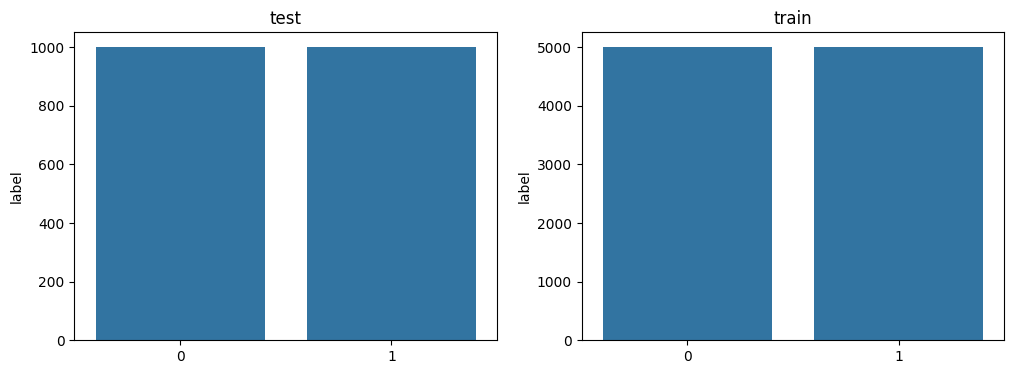

In [ ]:
labels_dict = imdb_df_test['label'].value_counts()
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
sns.barplot(labels_dict)
plt.title('test')

labels = imdb_df_train['label'].value_counts()
plt.subplot(1, 2, 2)
sns.barplot(labels)
plt.title('train')

## Data Pre-processing

In [ ]:
class clean_load_data():
  def __init__(self, df):
    self.df = df
    self.data = self.df['text'].values
    self.labels = self.df['label'].values

  def preprocess_word(self, s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\d", '', s)
    s = re.sub(r"\s+", '', s)
    return s

  def load_data(self):
    all_words, dataset = [], []
    for comment in self.data:
      for word in comment.lower().split():
        word = self.preprocess_word(word)
        if word not in stopwords.words("english") and word != '':
          all_words.append(word)

    counter = Counter(all_words)
    freq_words = sorted(counter, key = counter.get, reverse = True)[: 2000]
    words_to_idx = {word: idx for idx, word in enumerate(freq_words)}

    for id, comment in enumerate(self.data):
      comment_encode = [torch.tensor([words_to_idx[self.preprocess_word(word)]]) \
                        for word in comment.lower().split() if self.preprocess_word(word) in words_to_idx]
      dataset.append((comment_encode, self.labels[id]))
    return dataset, words_to_idx

In [ ]:
train_dataset, train_words_to_idx = clean_load_data(imdb_df_train).load_data()
test_dataset, test_words_to_idx = clean_load_data(imdb_df_test).load_data()

In [ ]:
random.seed(42)
random.shuffle(train_dataset)

## Model

In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, embed_size):
    super(BiLSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.embed_size = embed_size
    self.embed = nn.Embedding(input_size, embed_size)

    self.W_f = nn.Parameter(torch.empty(hidden_size, hidden_size))
    self.U_f = nn.Parameter(torch.empty(embed_size, hidden_size))
    self.b_f = nn.Parameter(torch.empty(1, hidden_size))

    self.W_i = nn.Parameter(torch.empty(hidden_size, hidden_size))
    self.U_i = nn.Parameter(torch.empty(embed_size, hidden_size))
    self.b_i = nn.Parameter(torch.empty(1, hidden_size))

    self.W_o = nn.Parameter(torch.empty(hidden_size, hidden_size))
    self.U_o = nn.Parameter(torch.empty(embed_size, hidden_size))
    self.b_o = nn.Parameter(torch.empty(1, hidden_size))

    self.W_c = nn.Parameter(torch.empty(hidden_size, hidden_size))
    self.U_c = nn.Parameter(torch.empty(embed_size, hidden_size))
    self.b_c = nn.Parameter(torch.empty(1, hidden_size))

    self.fc = nn.Linear(hidden_size * 2, 2)

    for weight in self.parameters():
      weight.data.uniform_(-0.5, 0.5)

  def forward_each_input(self, pre_hidden, pre_cell, input):
    input = self.embed(input)

    forget_gate = torch.sigmoid(torch.matmul(pre_hidden, self.W_f) + torch.matmul(input, self.U_f) + self.b_f)
    input_gate = torch.sigmoid(torch.matmul(pre_hidden, self.W_i) + torch.matmul(input, self.U_i) + self.b_i)
    output_gate = torch.sigmoid(torch.matmul(pre_hidden, self.W_o) + torch.matmul(input, self.U_o) + self.b_o)

    new_cell = torch.tanh(torch.matmul(pre_hidden, self.W_c) + torch.matmul(input, self.U_c) + self.b_c)
    output_cell = torch.mul(forget_gate, pre_hidden) + torch.mul(input_gate, new_cell)
    output_hidden = torch.mul(output_gate, output_cell)

    return output_hidden, output_cell

  def forward(self, comment_encode):
      output_hidden, output_cell = self.initialize()
      output_hiddens = []
      for id in range(len(comment_encode)):
        output_hidden, output_cell = self.forward_each_input(output_hidden, output_cell, comment_encode[id])
        output_hiddens.append(output_hidden)

      output_hidden, output_cell = self.initialize()
      output_tensor = torch.zeros(1, self.hidden_size * 2)
      for id in range(len(comment_encode)):
        output_hidden, output_cell = self.forward_each_input(output_hidden, output_cell, comment_encode[len(comment_encode) - 1 - id])
        output_hiddens[len(comment_encode) - 1 - id] = torch.cat((output_hidden, output_hiddens[len(comment_encode) - 1 - id]), dim = 1)
        output_tensor += output_hiddens[len(comment_encode) - 1 - id]

      output = self.fc(output_tensor / len(comment_encode))
      return output

  def initialize(self):
    return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size)

## Training

In [ ]:
def train(model, criterion, optimizer, n_epochs):
  history = []
  for epoch in range(n_epochs):
    print('--------------------------------')
    total_loss, train_count = 0, 0
    for i, (comment_encode, label) in enumerate(train_dataset):
      pred = model(comment_encode)
      arg_pred = torch.argmax(pred)
      if arg_pred == torch.tensor(label):
        train_count += 1
      loss = criterion(pred, torch.tensor([label], dtype = torch.long))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if i % 4 == 0:
        print("With i = {}, loss is {}".format(i, loss.item()))
      total_loss += loss.item()
      history.append(loss.item())
    print("Epoch {}, all loss is {}, the accuracy is {}".format(epoch, total_loss, train_count / len(train_dataset) * 100))
  return history

input_shape = len(train_words_to_idx)
embed_shape = 80
hidden_shape = 200
model = BiLSTM(input_shape, hidden_shape, embed_shape)

n_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
history = train(model = model, criterion = criterion, optimizer = optimizer, n_epochs = n_epochs)

Streaming output truncated to the last 5000 lines.
With i = 880, loss is nan
With i = 884, loss is nan
With i = 888, loss is nan
With i = 892, loss is nan
With i = 896, loss is nan
With i = 900, loss is nan
With i = 904, loss is nan
With i = 908, loss is nan
With i = 912, loss is nan
With i = 916, loss is nan
With i = 920, loss is nan
With i = 924, loss is nan
With i = 928, loss is nan
With i = 932, loss is nan
With i = 936, loss is nan
With i = 940, loss is nan
With i = 944, loss is nan
With i = 948, loss is nan
With i = 952, loss is nan
With i = 956, loss is nan
With i = 960, loss is nan
With i = 964, loss is nan
With i = 968, loss is nan
With i = 972, loss is nan
With i = 976, loss is nan
With i = 980, loss is nan
With i = 984, loss is nan
With i = 988, loss is nan
With i = 992, loss is nan
With i = 996, loss is nan
With i = 1000, loss is nan
With i = 1004, loss is nan
With i = 1008, loss is nan
With i = 1012, loss is nan
With i = 1016, loss is nan
With i = 1020, loss is nan
With i 

## Visualize

In [ ]:
plt.style.use('seaborn')
plt.title('loss')
plt.plot(history, c = 'blue', label = 'loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Infer

In [ ]:
with torch.no_grad():
  countMatch = 0
  for (comment_encode, label) in test_dataset:
    pred = model(comment_encode)
    arg_pred = torch.argmax(pred)
    if arg_pred == torch.tensor(label):
      countMatch += 1
  print("The val accuracy is {}%".format(countMatch / len(test_dataset) * 100))